In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Cargar y limpiar datos
# ---------------------------
df_train = pd.read_parquet("../../data/train/train_con_outliers.parquet")
cols_drop = [
    "media_diff_1h", "media_diff_45m", "media_diff_20m", "media_diff_10m", "media_diff_5m",
    "despegues_previos_1h", "despegues_previos_45m", "despegues_previos_20m", "despegues_previos_10m", "despegues_previos_5m",
    # 'distancias_holdings_0', 'distancias_holdings_1', 'distancias_holdings_2', 'distancia_en_pista_0', 'distancia_en_pista_1',
    # 'distancia_yendo_a_pista_0', 'distancia_yendo_a_pista_1', 'distancia_yendo_a_pista_2',
    # 'tiempo_holding_0', 'tiempo_holding_1', 'tiempo_holding_2',
    "temp", "wind_shear"
]
df_train.drop(columns=cols_drop, inplace=True)
df_train.dropna(inplace=True)
# Extraer día para split por grupos
if 'ts' in df_train.columns:
    df_train['day'] = pd.to_datetime(df_train['ts']).dt.date
else:
    df_train['day'] = np.random.randint(1, 10, size=len(df_train))

target = 'tiempo_hasta_despegue'
features = [c for c in df_train.columns if c not in (target, 'day', 'ts')]

X_train = df_train[features]
y_train = df_train[target]

# Aplicar log1p a la variable respuesta
y_train_log = np.log1p(y_train)

# ---------------------------
# Definir segmentación
# ---------------------------
def assign_segment(row):
    if (row['holding_ocupado']==0 and row['pista_ocupada']==0 and row['en_camino_antes']==0): return 'todo_libre'
    elif (row['holding_ocupado']==0 and row['pista_ocupada']==1 and row['en_camino_antes']==0): return 'solo_pista'
    elif (row['holding_ocupado']==1 and row['pista_ocupada']==0 and row['en_camino_antes']==0): return 'solo_holding'
    elif (row['holding_ocupado']==0 and row['pista_ocupada']==0 and row['en_camino_antes']==1): return 'solo_camino'
    else: return 'multiple'

# ---------------------------
# Preparar datos segmentados
def create_segmented_data(df):
    df = df.copy().reset_index(drop=True)
    df['segment'] = df.apply(assign_segment, axis=1)
    segments = {}
    for seg in df['segment'].unique():
        sub = df[df['segment']==seg]
        segments[seg] = {
            'X': sub.drop(columns=[target, 'segment', 'runway']),
            'y': sub[target],
            'count': len(sub)
        }

    return segments

train_segments = {}
for runway in X_train['runway'].unique():
    df_r = pd.concat([X_train, y_train], axis=1)
    df_r = df_r[df_r['runway']==runway]
    train_segments[f'runway_{int(runway)}'] = create_segmented_data(df_r)

# ---------------------------
# Grid Search: parámetros ampliados
# ---------------------------
param_grid = {
    'n_estimators':    [50, 100, 200, 300],
    'max_depth':       [2, 3, 4, 5, 6],
    'learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'subsample':       [0.8, 0.9, 1.0]
}

# ---------------------------
# Entrenar modelos con GridSearchCV en log-space
# ---------------------------
models = {}
for runway, segs in train_segments.items():
    models[runway] = {}
    for seg_name, data in segs.items():
        if data['count'] > 100:
            print(f"GridSearch para {runway}-{seg_name} ({data['count']} muestras)...")
            tscv = TimeSeriesSplit(n_splits=3) 
            gs = GridSearchCV(
                GradientBoostingRegressor(random_state=42),
                param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
            gs.fit(data['X'], data['y'])
            models[runway][seg_name] = gs.best_estimator_
            print(f"  Mejor params: {gs.best_params_}")
        else:
            print(f"Insuficientes datos para {runway}-{seg_name}: {data['count']} muestras")
            models[runway][seg_name] = None

# Modelo general log-space
print("Entrenando modelo general (log-space)...")
tscv = TimeSeriesSplit(n_splits=3) 
gs_general = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
gs_general.fit(X_train, y_train_log)
general_model = gs_general.best_estimator_
print(f"Mejores params (general): {gs_general.best_params_}\n")

GridSearch para runway_3-solo_pista (17872 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
GridSearch para runway_3-todo_libre (5822 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
GridSearch para runway_3-solo_holding (685 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
GridSearch para runway_3-solo_camino (2880 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
GridSearch para runway_3-multiple (5774 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
GridSearch para runway_2-solo_camino (494 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.9}
GridSearch para runway_2-solo_pista (7869 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_

=== Métricas Globales ===
MAE:  72.69
RMSE: 105.37
R²:   0.14

=== Métricas por Segmento ===
                    MAE   Count
segment                        
multiple      91.689366  1857.0
solo_camino   77.123207   817.0
solo_holding  98.992301   278.0
solo_pista    61.545451  7301.0
todo_libre    84.475061  2988.0 

=== Métricas por Pista ===
              MAE   Count
runway                   
0.0     70.043391  1347.0
1.0     92.303868  3886.0
2.0     58.596399  2827.0
3.0     66.369078  5181.0 

=== Métricas por Holding Point ===
                      MAE   Count
holding_point                    
0.0             74.177276    31.0
2.0             58.221743  1165.0
3.0            145.714926   182.0
4.0             61.573216  1668.0
5.0             64.938410   582.0
6.0             43.594005   577.0
7.0             68.287677  2268.0
8.0             62.993119  2389.0
9.0             73.411124   493.0
10.0            76.736646  1419.0
11.0           101.150432  1278.0
12.0           139.

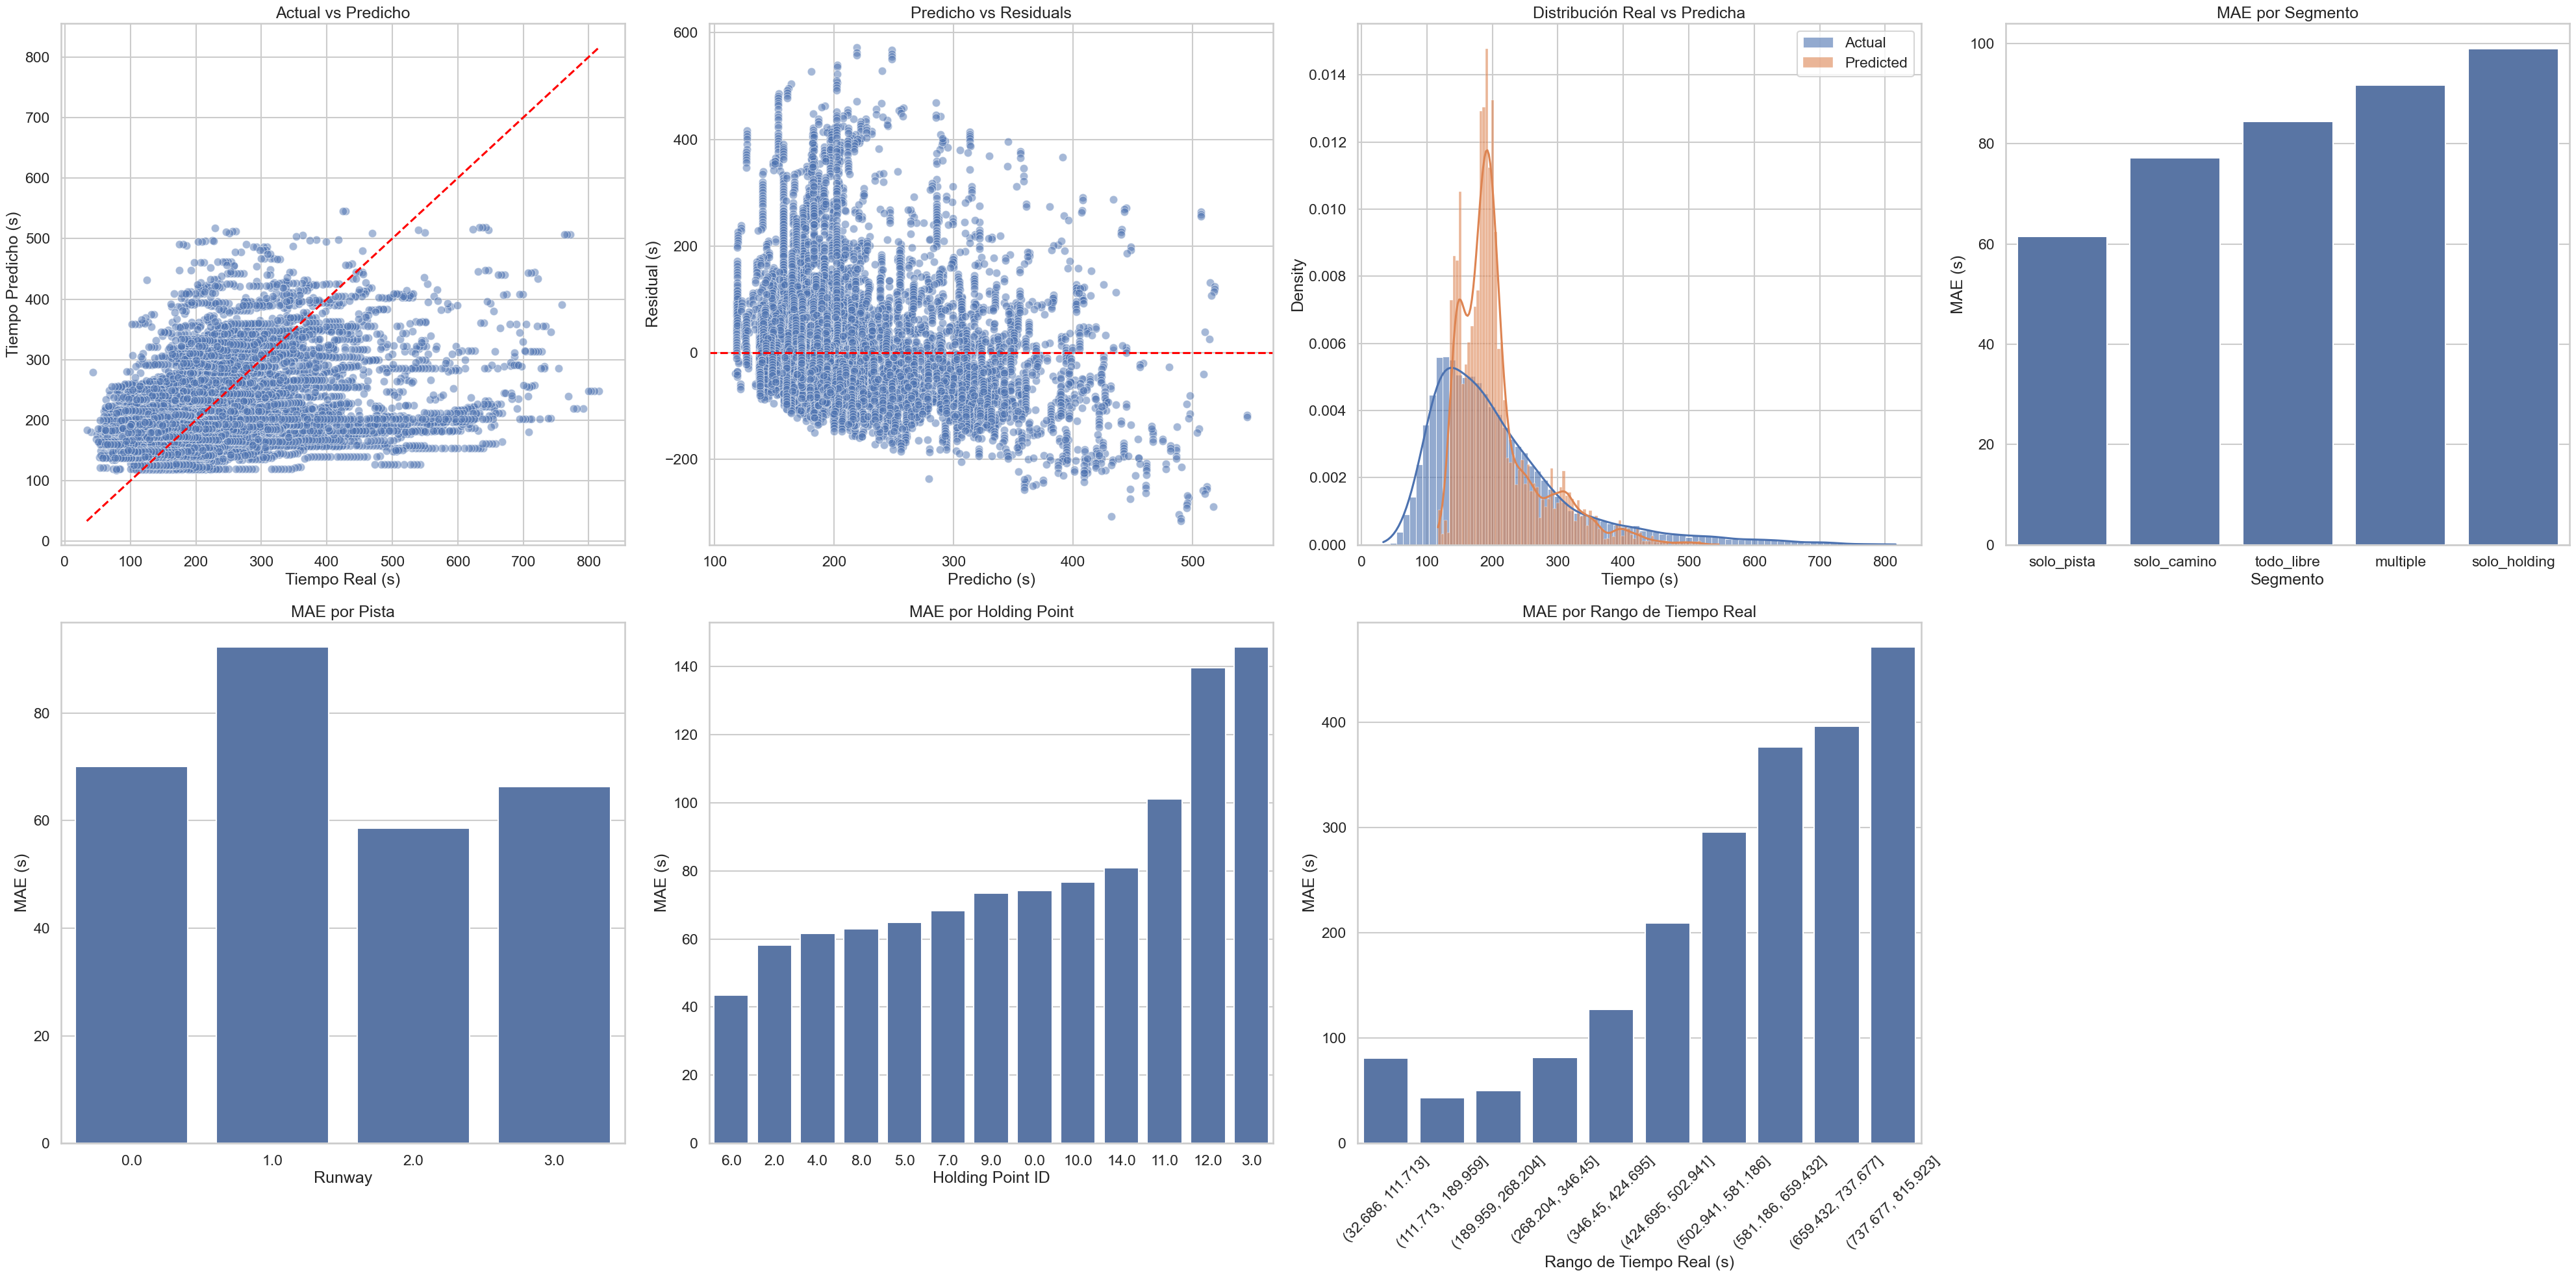

In [5]:
# ---------------------------
# Función de predicción e inversa de log
# ---------------------------
def predict_by_segment(X, y, models, general_model):
    df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    df['segment'] = df.apply(assign_segment, axis=1)
    results = []
    for _, row in df.iterrows():
        key = f"runway_{int(row['runway'])}"
        seg = row['segment']
        model = models.get(key, {}).get(seg) or general_model
        X_row = row.drop([target, 'segment', "runway"]).values.reshape(1, -1)
        try:
            pred = model.predict(X_row)[0]
            results.append({
                'actual': row[target], 'predicted': pred,
                'runway': row['runway'], 'segment': seg,
                'holding_point': row['holding_point_id'] if 'holding_point_id' in row.index else None
            })
        except:
            pass
    return pd.DataFrame(results)

# ---------------------------
# 1) Carga y predicción
# ---------------------------
df_test = pd.read_parquet("../../data/test/test_con_outliers.parquet").drop(columns=["ts"]).dropna()
df_test = df_test.drop(columns=cols_drop, errors='ignore')

if target in df_test.columns:
    X_test = df_test.drop(columns=[target])
    y_test = df_test[target]
else:
    X_test = df_test
    y_test = pd.Series([np.nan] * len(df_test))

test_results = predict_by_segment(X_test, y_test, models, general_model)

# ---------------------------
# 2) Cálculo de métricas
# ---------------------------
# Globales
mae   = mean_absolute_error(test_results.actual,    test_results.predicted)
rmse  = np.sqrt(     mean_squared_error(test_results.actual, test_results.predicted))
r2    = r2_score(    test_results.actual,    test_results.predicted)

# Por segmento
seg_metrics    = test_results.groupby('segment').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)
# Por pista (runway)
runway_metrics = test_results.groupby('runway').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)
# Por holding_point (si existe)
if test_results['holding_point'].notna().any():
    hp_metrics = test_results.groupby('holding_point').apply(
        lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
    )
else:
    hp_metrics = None
# Por rango de tiempo real
test_results['actual_bin'] = pd.cut(test_results.actual, bins=10)
bin_metrics = test_results.groupby('actual_bin').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)

# ---------------------------
# 3) Impresión de resultados
# ---------------------------
print("=== Métricas Globales ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}\n")

print("=== Métricas por Segmento ===")
print(seg_metrics, "\n")

print("=== Métricas por Pista ===")
print(runway_metrics, "\n")

if hp_metrics is not None:
    print("=== Métricas por Holding Point ===")
    print(hp_metrics, "\n")

print("=== Métricas por Rango de Tiempo Real ===")
print(bin_metrics, "\n")

# ---------------------------
# 4) Gráficas con seaborn
# ---------------------------
sns.set(style="whitegrid", context="talk")
rows, cols = 2, 4
fig, axs = plt.subplots(rows, cols, figsize=(40, 20))
axs = axs.flatten()

# 1) Actual vs Predicho
sns.scatterplot(x="actual", y="predicted", data=test_results, ax=axs[0], alpha=0.5)
axs[0].plot(
    [test_results.actual.min(), test_results.actual.max()],
    [test_results.actual.min(), test_results.actual.max()],
    '--', color='red'
)
axs[0].set_title('Actual vs Predicho')
axs[0].set_xlabel('Tiempo Real (s)')
axs[0].set_ylabel('Tiempo Predicho (s)')

# 2) Predicho vs Residuals
test_results["residual"] = test_results["actual"] - test_results["predicted"]
sns.scatterplot(x="predicted", y="residual", data=test_results, ax=axs[1], alpha=0.5)
axs[1].axhline(0, linestyle='--', color='red')
axs[1].set_title('Predicho vs Residuals')
axs[1].set_xlabel('Predicho (s)')
axs[1].set_ylabel('Residual (s)')

# 3) Distribución Real vs Predicha con bins
sns.histplot(test_results["actual"], kde=True, stat="density", alpha=0.6, label='Actual', ax=axs[2])
sns.histplot(test_results["predicted"], kde=True, stat="density", alpha=0.6, label='Predicted', ax=axs[2])
axs[2].set_title('Distribución Real vs Predicha')
axs[2].set_xlabel('Tiempo (s)')
axs[2].legend()

# 4) MAE por Segmento
seg_order = seg_metrics["MAE"].sort_values().index
sns.barplot(x=seg_metrics.loc[seg_order].index, y=seg_metrics.loc[seg_order]["MAE"], ax=axs[3])
axs[3].set_title('MAE por Segmento')
axs[3].set_xlabel('Segmento')
axs[3].set_ylabel('MAE (s)')

# 5) MAE por Pista
sns.barplot(x=runway_metrics.index.astype(str), y=runway_metrics["MAE"], ax=axs[4])
axs[4].set_title('MAE por Pista')
axs[4].set_xlabel('Runway')
axs[4].set_ylabel('MAE (s)')

# 6) MAE por Holding Point
if hp_metrics is not None:
    hp_order = hp_metrics["MAE"].sort_values().index
    sns.barplot(x=hp_order.astype(str), y=hp_metrics.loc[hp_order]["MAE"], ax=axs[5])
    axs[5].set_title('MAE por Holding Point')
    axs[5].set_xlabel('Holding Point ID')
    axs[5].set_ylabel('MAE (s)')
else:
    axs[5].axis('off')

# 7) MAE por Rango de Tiempo Real
sns.barplot(x=bin_metrics.index.astype(str), y=bin_metrics["MAE"], ax=axs[6])
axs[6].set_title('MAE por Rango de Tiempo Real')
axs[6].set_xlabel('Rango de Tiempo Real (s)')
axs[6].set_ylabel('MAE (s)')
axs[6].tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos
for ax in axs[7:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


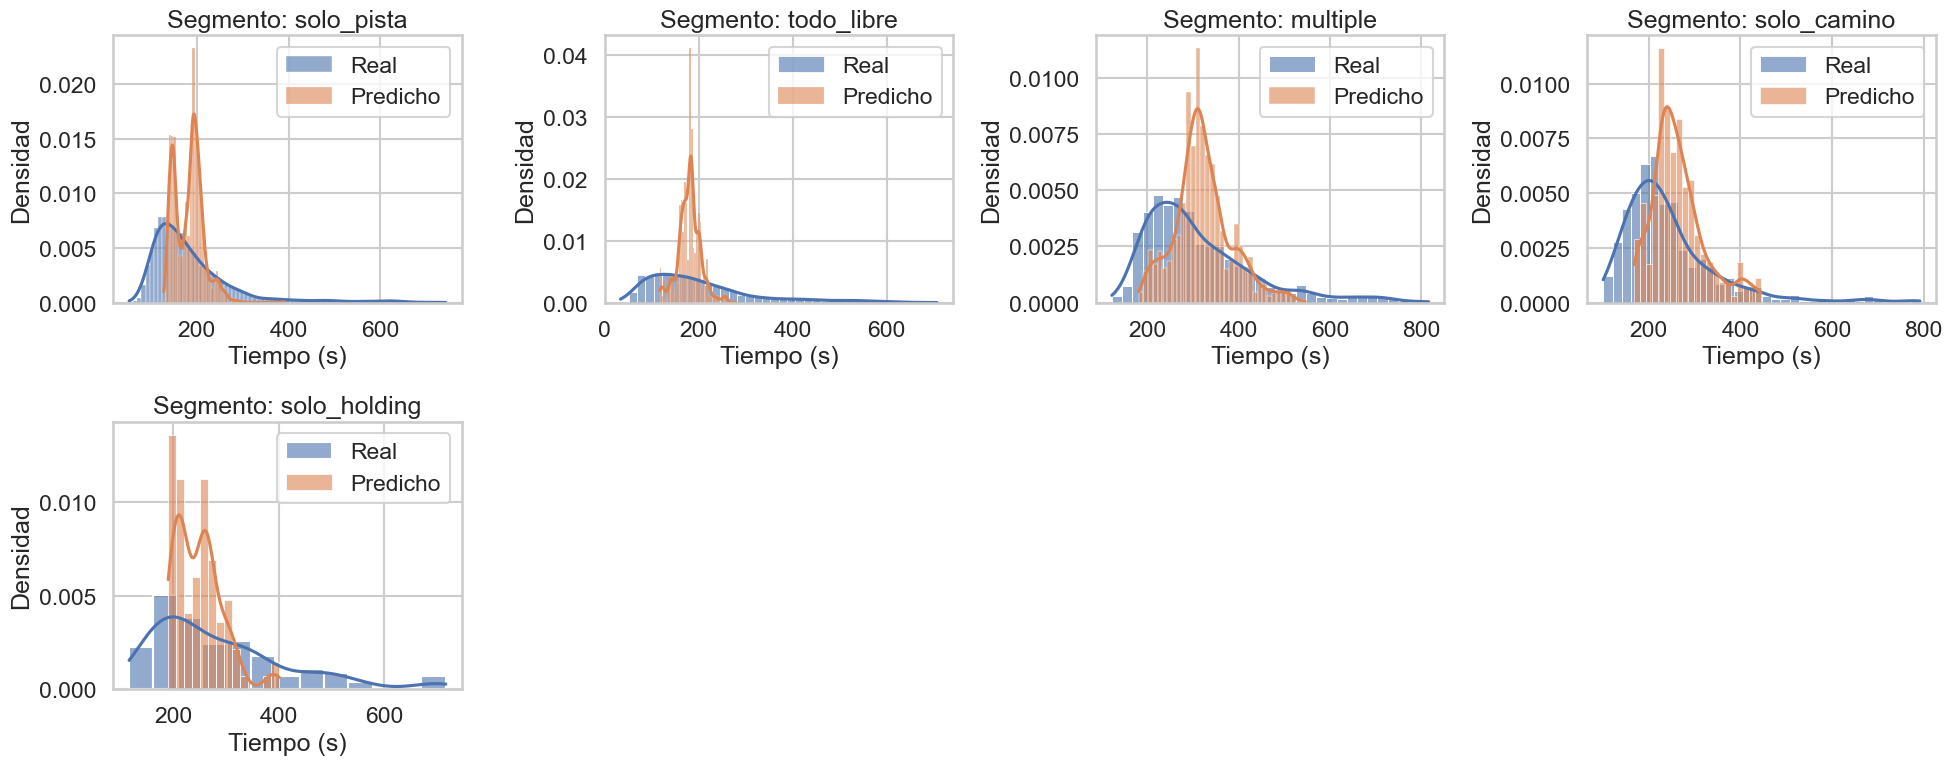

In [6]:
# ---------------------------
# 5) Distribución Real vs Predicha por Segmento
# ---------------------------
segments = test_results['segment'].unique()
n_seg = len(segments)
# Definimos un grid de subplots (4 columnas como ejemplo)
cols = 4
rows = int(np.ceil(n_seg / cols))
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axs = axs.flatten()

for ax, seg in zip(axs, segments):
    df_seg = test_results[test_results['segment'] == seg]
    # Histograma real
    sns.histplot(
        df_seg["actual"],
        kde=True,
        stat="density",
        alpha=0.6,
        label='Real',
        ax=ax
    )
    # Histograma predicho
    sns.histplot(
        df_seg["predicted"],
        kde=True,
        stat="density",
        alpha=0.6,
        label='Predicho',
        ax=ax
    )
    ax.set_title(f'Segmento: {seg}')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Densidad')
    ax.legend()

# Si hay ejes sobrantes, los ocultamos
for ax in axs[n_seg:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
